## LSTM Recurrent Neural Network
- train model on google stock prices from 2012 to 2016
- predict on jan 2017

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


### Import the dataset

In [2]:
train_df = pd.read_csv('Google_Stock_Price_Train.csv')
print(train_df.shape[0])
train_df.head()

1258


,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [22]:
test_df = pd.read_csv('Google_Stock_Price_Test.csv')
test = test_df.iloc[:,1:2].values
print(test_df.shape[0])
print(test_df.head())
test[0:5]

20
       Date    Open    High     Low   Close     Volume
0  1/3/2017  778.81  789.63  775.80  786.14  1,657,300
1  1/4/2017  788.36  791.34  783.16  786.90  1,073,000
2  1/5/2017  786.08  794.48  785.02  794.02  1,335,200
3  1/6/2017  795.26  807.90  792.20  806.15  1,640,200
4  1/9/2017  806.40  809.97  802.83  806.65  1,272,400


array([[778.81],
       [788.36],
       [786.08],
       [795.26],
       [806.4 ]])

- only get the opening stock price
- use reshape to convert to column vector
- apply feature scaling

In [11]:
train = (train_df.iloc[:, 1].values).reshape(-1,1)
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
train[0:5]

array([[325.25],
       [331.27],
       [329.83],
       [328.34],
       [322.04]])

### create training set structure
- 60 previous days to predict the 61st day

In [12]:
X_train = []
y_train = []

for i in range(60, len(train)):
    X_train.append(scaled_train[i-60:i,0])
    y_train.append(scaled_train[i,0])

X_train = np.array(X_train)
y_train = np.array(y_train) 

- reshape for a keras RNN https://keras.io/layers/recurrent/
- https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e

In [13]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

- get the previous data, reshape, scale

In [67]:
allOpen = pd.concat((train_df['Open'], test_df['Open']), axis=0) # vertical 
inputs  = allOpen[len(allOpen)-len(test_df)-60:].values
inputs  = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test  = []

for i in range(60, 80):
    X_test.append(inputs[i-60:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 

### Build the RNN

In [18]:
regressor = Sequential()

# first layer
regressor.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(.25))
# second layer
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(.25))
# third layer
regressor.add(LSTM(units=64, return_sequences=True))
regressor.add(Dropout(.25))
# fourth layer
regressor.add(LSTM(units=64))
regressor.add(Dropout(.25))
# output layer
regressor.add(Dense(units=1))

- compile the network

In [18]:
regressor.compile(optimizer='adam', loss='mean_squared_error')

- fit the network

In [19]:
regressor.fit(X_train, y_train, epochs=96, batch_size=32)

Epoch 1/96
1198/1198 [==============================] - 6s 5ms/step - loss: 0.0503
Epoch 2/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0082
Epoch 3/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0060
Epoch 4/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0060
Epoch 5/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0050
Epoch 6/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0050
Epoch 7/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0052
Epoch 8/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0052
Epoch 9/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0044
Epoch 10/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0043
Epoch 11/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0041
Epoch 12/96
1198/1198 [==============================] - 4s 3ms/step - loss: 0.0039
E

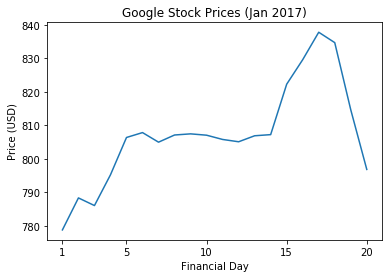

In [52]:
plt.plot(test)
plt.title("Google Stock Prices (Jan 2017)")
plt.xlabel("Financial Day")
plt.ylabel("Price (USD)")
plt.xticks([0,4,9,14,19], ["1", "5","10","15","20"])
plt.show()

### Predict the january stock prices

In [70]:
predicted_prices = regressor.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

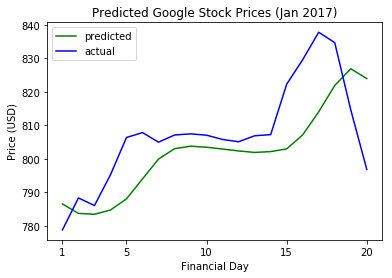

In [80]:
plt.plot(predicted_prices, color='green', label='predicted')
plt.plot(test, color='blue', label='actual')
plt.title("Predicted Google Stock Prices (Jan 2017)")
plt.xlabel("Financial Day")
plt.ylabel("Price (USD)")
plt.xticks([0,4,9,14,19], ["1", "5","10","15","20"])
plt.legend()
plt.show()

In [86]:
res = (test - predicted_prices) / (840 - 780)
res = np.square(res)

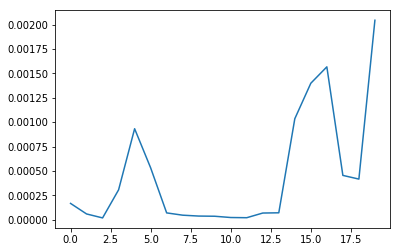

In [87]:
plt.plot(res/100)

In [15]:
X_train.shape

(1198, 60, 1)